In [1]:
import copy
import GPyOpt
import GPy
import uncertaninity_baestorms as ubay
import numpy as np
import matplotlib.pyplot as plt
import baestorm
from pyswmm_lite import environment

In [2]:
# Generate Gaussian Flows
def GaussianSignal(x, amplitude, timetopeak, dispersion):
    flows = (
        amplitude
        * (1.0 / (dispersion * (np.sqrt(2.0 * np.pi))))
        * np.exp(-0.5 * ((x - timetopeak) / dispersion) ** 2)
    )
    return flows


# Objective function
def ObjectiveFunction(actions):
    # Sample the rainevent
    padding_length = 500
    temp_x = np.linspace(-10.0, 10.0, 100)

    def flows_amp(amp):
        return np.pad(
            GaussianSignal(temp_x, amp, -2.0, 3.0), (0, padding_length), "constant"
        )

    # Pick a random stormevent - Uniformly Sampled
    amplitude = np.random.choice(np.linspace(10.0, 20.0, 100), size=1)
    flows = flows_amp(amplitude)
    env = environment(baestorm.load_networks("parallel"), False)

    reward = 0.0
    for time in range(0, len(flows)):
        # Set the gata position
        env._setValvePosition("1", actions)
        #env._setValvePosition("2", actions[1])

        # Set inflows
        env.sim._model.setNodeInflow("P1", flows[time])
        env.sim._model.setNodeInflow("P2", 0.0)#flows[time])

        # compute performance
        flow = env.methods["flow"]("8")
        if flow > 0.50:
            reward += 10.0 * (flow - 0.50)
        else:
            reward += 0.0

        if (env.sim._model.getNodeResult("P1", 4) + env.sim._model.getNodeResult("P2", 4) > 0.0):
            reward += 10 ** 5
        else:
            reward += 0.0

        # Record data
        _ = env.step()
    env._terminate()
    return reward

In [3]:
# Create an objective function
class Objective:
    def f(self, x):
        # Convert 2d array to 1d
        x = x.flatten()
        reward = ObjectiveFunction(x) #ubay.ObjectiveFunction(x)
        return reward

In [4]:
# Initalize the objective
Obj_temp = Objective()
Obj_temp = GPyOpt.core.task.SingleObjective(Obj_temp.f)

# Create Search Space
Search_Space = GPyOpt.Design_space(space=[{"name": "var_1", "type": "continuous", "domain": (0.0, 1.0)}])
# Pick a kernel
kernel = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
# Set up the model
model = GPyOpt.models.GPModel(kernel=kernel,
                              noise_var=0.0,
                              optimize_restarts=5,
                              verbose=False)

# How do you sample the region
initial_design = GPyOpt.experiment_design.initial_design("random",
                                                         Search_Space,
                                                         2)

# Choose the acquision function
acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(Search_Space)
acquisition = GPyOpt.acquisitions.AcquisitionEI(model,
                                                Search_Space,
                                                acq_optimizer)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(model,
                                                Search_Space,
                                                Obj_temp,
                                                acquisition,
                                                evaluator,
                                                initial_design)

max_iter = 100
bo.run_optimization(path_to_save="./", max_iter=max_iter)

In [5]:
def plot_acquisition(axis, model):
    bounds = model.acquisition.space.get_bounds()

    x_grid = np.arange(bounds[0][0], bounds[0][1], 0.001)
    x_grid = x_grid.reshape(len(x_grid), 1)
    # acqu = model.acquisition.acquisition_function(x_grid)
    # acqu_normalized = (-acqu - min(-acqu)) / (max(-acqu - min(-acqu)))
    m, v = model.model.predict(x_grid)
    factor = max(m + 1.96 * np.sqrt(v)) - min(m - 1.96 * np.sqrt(v))
    axis.plot(x_grid, m, color="#D5313E", lw=2.0)
    axis.plot(x_grid, m - 1.96 * np.sqrt(v), color="#445792")
    axis.plot(x_grid, m + 1.96 * np.sqrt(v), color="#445792")
    axis.fill_between(
        np.ravel(x_grid),
        np.ravel(m - 1.96 * np.sqrt(v)),
        np.ravel(m + 1.96 * np.sqrt(v)),
        color="#445792",
        alpha=0.5,
    )
    y = model.Y - model.Y.mean()
    y = y / model.Y.std()
    axis.scatter(model.X[:-1], y[:-1], color="#9F383E", marker="o")

    axis.set_xlabel("Valve Setting")
    axis.set_ylabel("Objective")
    axis.set_ylim(
        min(m - 1.96 * np.sqrt(v)) - 0.25 * factor,
        max(m + 1.96 * np.sqrt(v)) + 0.05 * factor,
    )

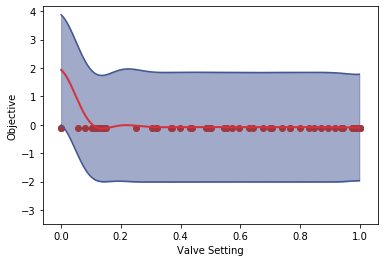

In [6]:
ax = plt.subplot(1, 1, 1)
plot_acquisition(ax, bo)

In [7]:
x = bo.X
y = bo.Y
# RBF and WhiteNoise kernel
#kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
#gp1 = GPy.models.GPRegression(x,y.reshape(-1,1),kernel1)
#gp1.optimize(messages=False)
#gp1.optimize_restarts(num_restarts = 100)

gp1 = copy.deepcopy(bo.model)
var_pref = np.zeros((x.shape[0],1))

eps = np.inf
iterations = 0

m, v = gp1.predict(x)
s = 10
variance_noise = np.zeros(len(x))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)

    kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
    gp2 = GPy.models.GPRegression(x,z.reshape(-1,1),kernel2)
    gp2.optimize(messages=False)
    gp2.optimize_restarts(num_restarts = 4)
    m_n, v_n = gp2.predict(x)

    kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
    gp3 = GPy.models.GPRegression(x,y.reshape(-1,1),kernel3)
    gp3.optimize(messages=False)
    gp3.optimize_restarts(num_restarts = 5)
    kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

    m, v = gp3.predict(x)
    
    diff = var_pref - v
    eps = np.dot(diff.T, diff)[0][0]
    gp1 = copy.deepcopy(gp3)
    var_pref = copy.deepcopy(v)
    print(eps)
    if eps < 5:
        break
    if iterations > 10:
        break
    iterations += 1

IndentationError: unexpected indent (<ipython-input-7-8162b3356af5>, line 25)

In [8]:
x = bo.X
y = bo.Y

gp1 = copy.deepcopy(bo.model)
var_pref = np.zeros((x.shape[0],1))

eps = np.inf
iterations = 0

m, v = gp1.predict(x)
s = 20
variance_noise = np.zeros(len(x))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)

In [9]:
kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x,z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 4)
m_n, v_n = gp2.predict(x)

Optimization restart 1/4, f = 280.38617759869436
Optimization restart 2/4, f = 280.38617763416306
Optimization restart 3/4, f = 280.38617759800286
Optimization restart 4/4, f = 280.38617759797495


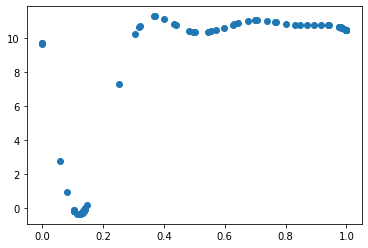

In [10]:
plt.plot(x, m_n, 'o')

In [11]:
kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
gp3 = GPy.models.GPRegression(x,y.reshape(-1,1),kernel3)
gp3.optimize(messages=False)
gp3.optimize_restarts(num_restarts = 5)
kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

Optimization restart 1/5, f = 97508.06543200806
Optimization restart 2/5, f = 104158.96917791042
Optimization restart 3/5, f = 94487.24701808681
Optimization restart 4/5, f = 96485.5890071559
Optimization restart 5/5, f = 107857.93620645563


In [12]:
m, v = gp3.predict(x)
    
diff = var_pref - v
eps = np.dot(diff.T, diff)[0][0]
gp1 = copy.deepcopy(gp3)
var_pref = copy.deepcopy(v)
print(eps)

5.771288783151633e+21
